In [16]:
#pip install python-gdcm

In [17]:
#pip install joblib

## RSNA Screening Mammography Breast Cancer Detection

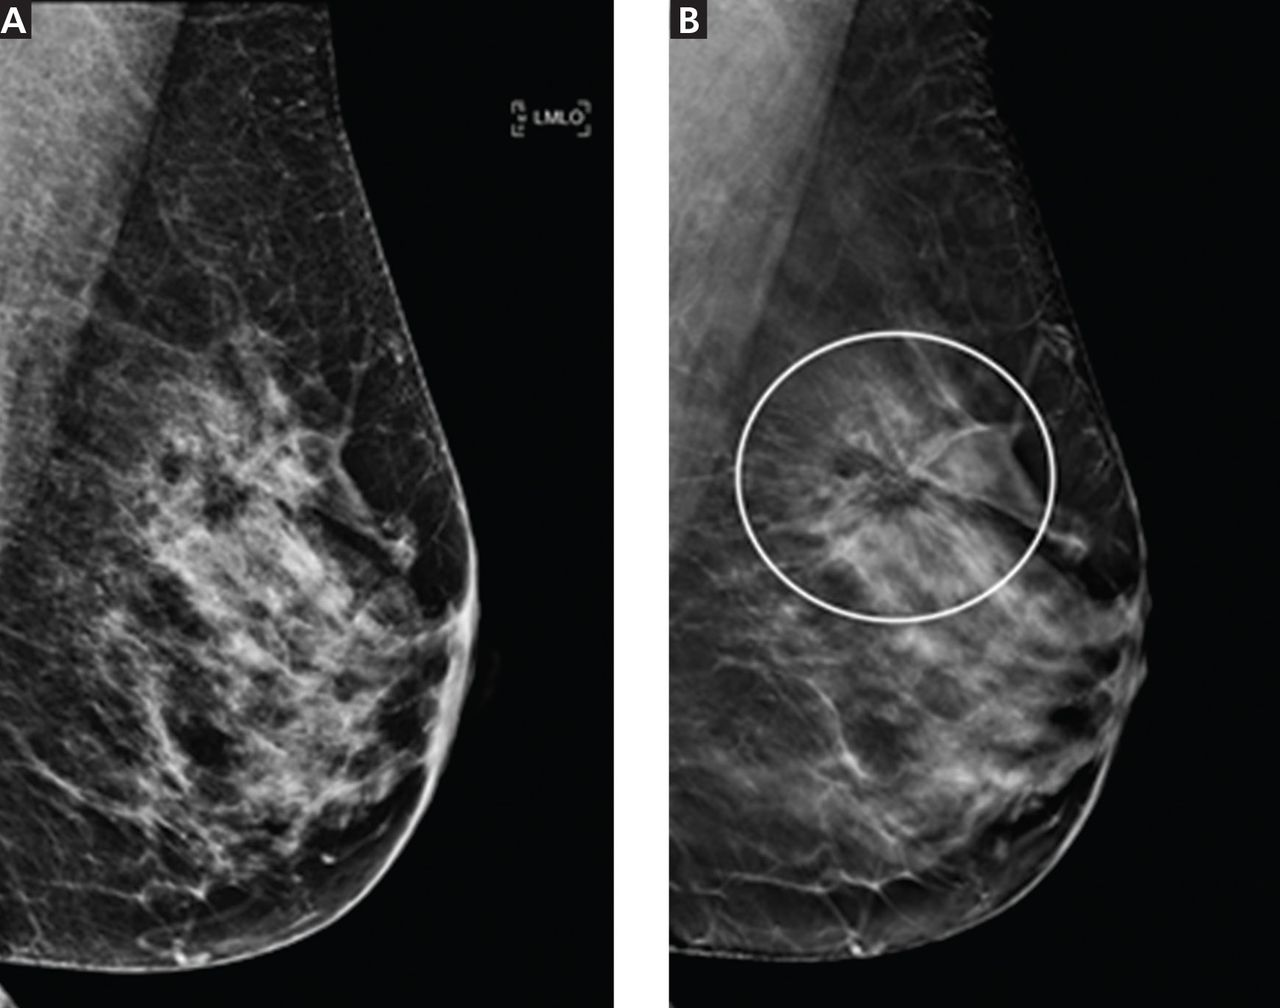

## Introduction
The ravaging effect of breast cancer on millions of people across the globe has shown to have a deleterious impact on the human population. According to the World Health Organization, in 2020 alone, there were 2.3 million new breast cancer diagnoses, with 685,000 mortality of these deaths. Most of these deaths result from misdiagnosis, delayed diagnosis, or lack of diagnostic tools, especially for people in developing nations.

The deluge of Mammography Breast Cancer datasets presents an excellent opportunity for AI tools to help streamline radiologists' workflow to help improve the diagnostic accuracy of screening mammography and save patients' lives.

**Modeling Objective:** The Goal of this project is to design a model that predicts the incidence of breast cancer

## Importing Libraries | Dependencies

In [66]:
import pydicom
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as  np
import os
import seaborn as sns
import random
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder, normalize
import time
import cv2
from tqdm.notebook import tqdm
#import aequitas as ae

BOLD = '\033[1m'
END = '\033[0m'

<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #2ab7ca; padding: 20px;">
    <h4>Load Data</h4>
    <p> The Wrangler Function Helps to Load of Data into memory and also adds the fullpath to each in mage in the dataset

In [19]:
path = '/kaggle/input/rsna-breast-cancer-detection/'
sample_sub =  pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/sample_submission.csv')

def wrangler(path, sample_sub):
    
    all_cancer_df = pd.read_csv(path +'train.csv')
    df_cancer_test = pd.read_csv(path+'test.csv')
    
    all_cancer_df['image_id'] = all_cancer_df['image_id'].astype(str) + ".dcm" 
    all_image_paths = {os.path.basename(x): x for x in 
                   glob.glob(os.path.join(path,'train_images*', '*', '*.dcm'))}
    
    all_cancer_df['path'] = all_cancer_df['image_id'].map(all_image_paths.get)

    return (all_cancer_df, df_cancer_test)

In [20]:
#Loading of Test and Training Data into Memory
all_cancer_df, df_cancer_test =  wrangler(path, sample_sub)

<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #2ab7ca; padding: 20px;">
    <h4>Snapshot of Data</h4>
    <p> This will allowed me to see what my data looks like and gain information on how to process and make decisions with the respect to the data at hand

In [21]:
all_cancer_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612.dcm,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
1,2,10006,1459541791.dcm,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
2,2,10006,1864590858.dcm,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
3,2,10006,1874946579.dcm,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...
4,2,10011,220375232.dcm,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-detection/tra...


In [22]:
all_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  object 
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  path                  

In [23]:
df_cancer_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [24]:
df_cancer_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   site_id        4 non-null      int64 
 1   patient_id     4 non-null      int64 
 2   image_id       4 non-null      int64 
 3   laterality     4 non-null      object
 4   view           4 non-null      object
 5   age            4 non-null      int64 
 6   implant        4 non-null      int64 
 7   machine_id     4 non-null      int64 
 8   prediction_id  4 non-null      object
dtypes: int64(6), object(3)
memory usage: 416.0+ bytes


<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> 
    <h4> Finding </h4>
     <p>
         From Looking at the data above the following conclusions made
        <li>The Data has a combination of different data types (Object, Float, Int and Bool)
        <li> Some Columns have missing values  eg. density, BIRADS
        <li> Density
        <li> Birads
         <li> Total Data Entries are <b>54706 </b>
         <li> Data Also Contains Images stored as DICOM file

<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #2ab7ca; padding: 20px;">
    <h4>EXPLORATORY DATA ANALYIS</h4>
    <p>This section hopes to look at our data from different lenses with an open-ended mind
    in order to determine the quality of our data, provide basis for data cleaning techniques,
gain insight to the demographic distribution of our datasets and data was collected.
    <p>Below is a list of areas that we will be looking for in our exploratory data analysis.
    <li> Cardinality Check
    <li> Duplicate Values
    <li> Value Distributions - Is the dataset feature uniform, normal, skewed and severely unbalanced?
    <li> Scale of Numerical Features
    <li> Missing Values
    <li> Demography Analysis
    <li> Outlier Detection
    <li> Correlation 
    <li> Image Attributes

<div style="border: 2px solid #fed766; padding: 20px;">
    <h3> A. Cardinality Check

In [25]:
#Check for Cardinality 
def check_cardinality (df,catigorical_features):
    cat_df = df[catigorical_features]    
    
    feat_def = pd.DataFrame({
        "Columns":cat_df.columns,
        "Cardinality": cat_df.nunique()
    })
    
    return feat_def  

numCols = all_cancer_df.select_dtypes("number").columns
catCols = all_cancer_df.select_dtypes("object").columns
numCols= list(set(numCols))
catCols= list(set(catCols))


cardinalityCat = check_cardinality (all_cancer_df,catCols)
cardinalityNumeric = check_cardinality (all_cancer_df,numCols)

In [26]:
print(BOLD+'Cardinality of Numeric Features:',END)
print(cardinalityNumeric)
print("\n")
print(BOLD+'Cardinality of Categorical Features:',END)
print(cardinalityCat)

Cardinality of Numeric Features: 
               Columns  Cardinality
implant        implant            2
biopsy          biopsy            2
cancer          cancer            2
patient_id  patient_id        11913
invasive      invasive            2
age                age           63
site_id        site_id            2
BIRADS          BIRADS            3
machine_id  machine_id           10


Cardinality of Categorical Features: 
               Columns  Cardinality
laterality  laterality            2
image_id      image_id        54706
path              path        54706
view              view            6
density        density            4


<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> 
   <h4>Finding </h4>
     <p>
         The Following Fields Have High Cardinality
        <li>Machine Id
        <li>View
        <li> Density
        <li> Birads


<div style="border: 2px solid #fed766; padding: 20px;">
    <h3> B. MISSING VALUES

In [27]:
# Field(s) with high amount of Missing/Zero Values
def check_for_missing_and_null(df):
    df_copy = df.replace({'?': np.nan, "None":np.nan})
    null_df = pd.DataFrame({'columns': df_copy.columns, 
                            'percent_null': df_copy.isnull().sum() * 100 / len(df), 
                           'percent_zero': df_copy.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df
null_zero_values = check_for_missing_and_null(all_cancer_df)
null_zero_values

,columns,percent_null,percent_zero
site_id,site_id,0.000000,0.000000
patient_id,patient_id,0.000000,0.000000
image_id,image_id,0.000000,0.000000
laterality,laterality,0.000000,0.000000
view,view,0.000000,0.000000
age,age,0.067634,0.000000
cancer,cancer,0.000000,97.883230
biopsy,biopsy,0.000000,94.572807
invasive,invasive,0.000000,98.504734
BIRADS,BIRADS,51.950426,15.078785


<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;">      <h4> Finding</h4>
    Fields with High Amount of Missing/Zero Values Conclusion
    <p>Missing Value
        <li>BIRADS <b>51.9% </b>
    <li>Density <b>46.1% </b>
    <li>Age <b>0.01% </b>
   


<div style="border: 2px solid #fed766; padding: 20px;">
    <h3> C. DUPLICATE FIELDS

In [28]:
# Count the duplicated data 
sum(all_cancer_df.duplicated())

0

<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;">      <h4> Finding</h4>
    No Duplicate Data Found in the Dataset


<div style="border: 2px solid #fed766; padding: 20px;">
  <h3> D. Scale of Numerical Features </h3>

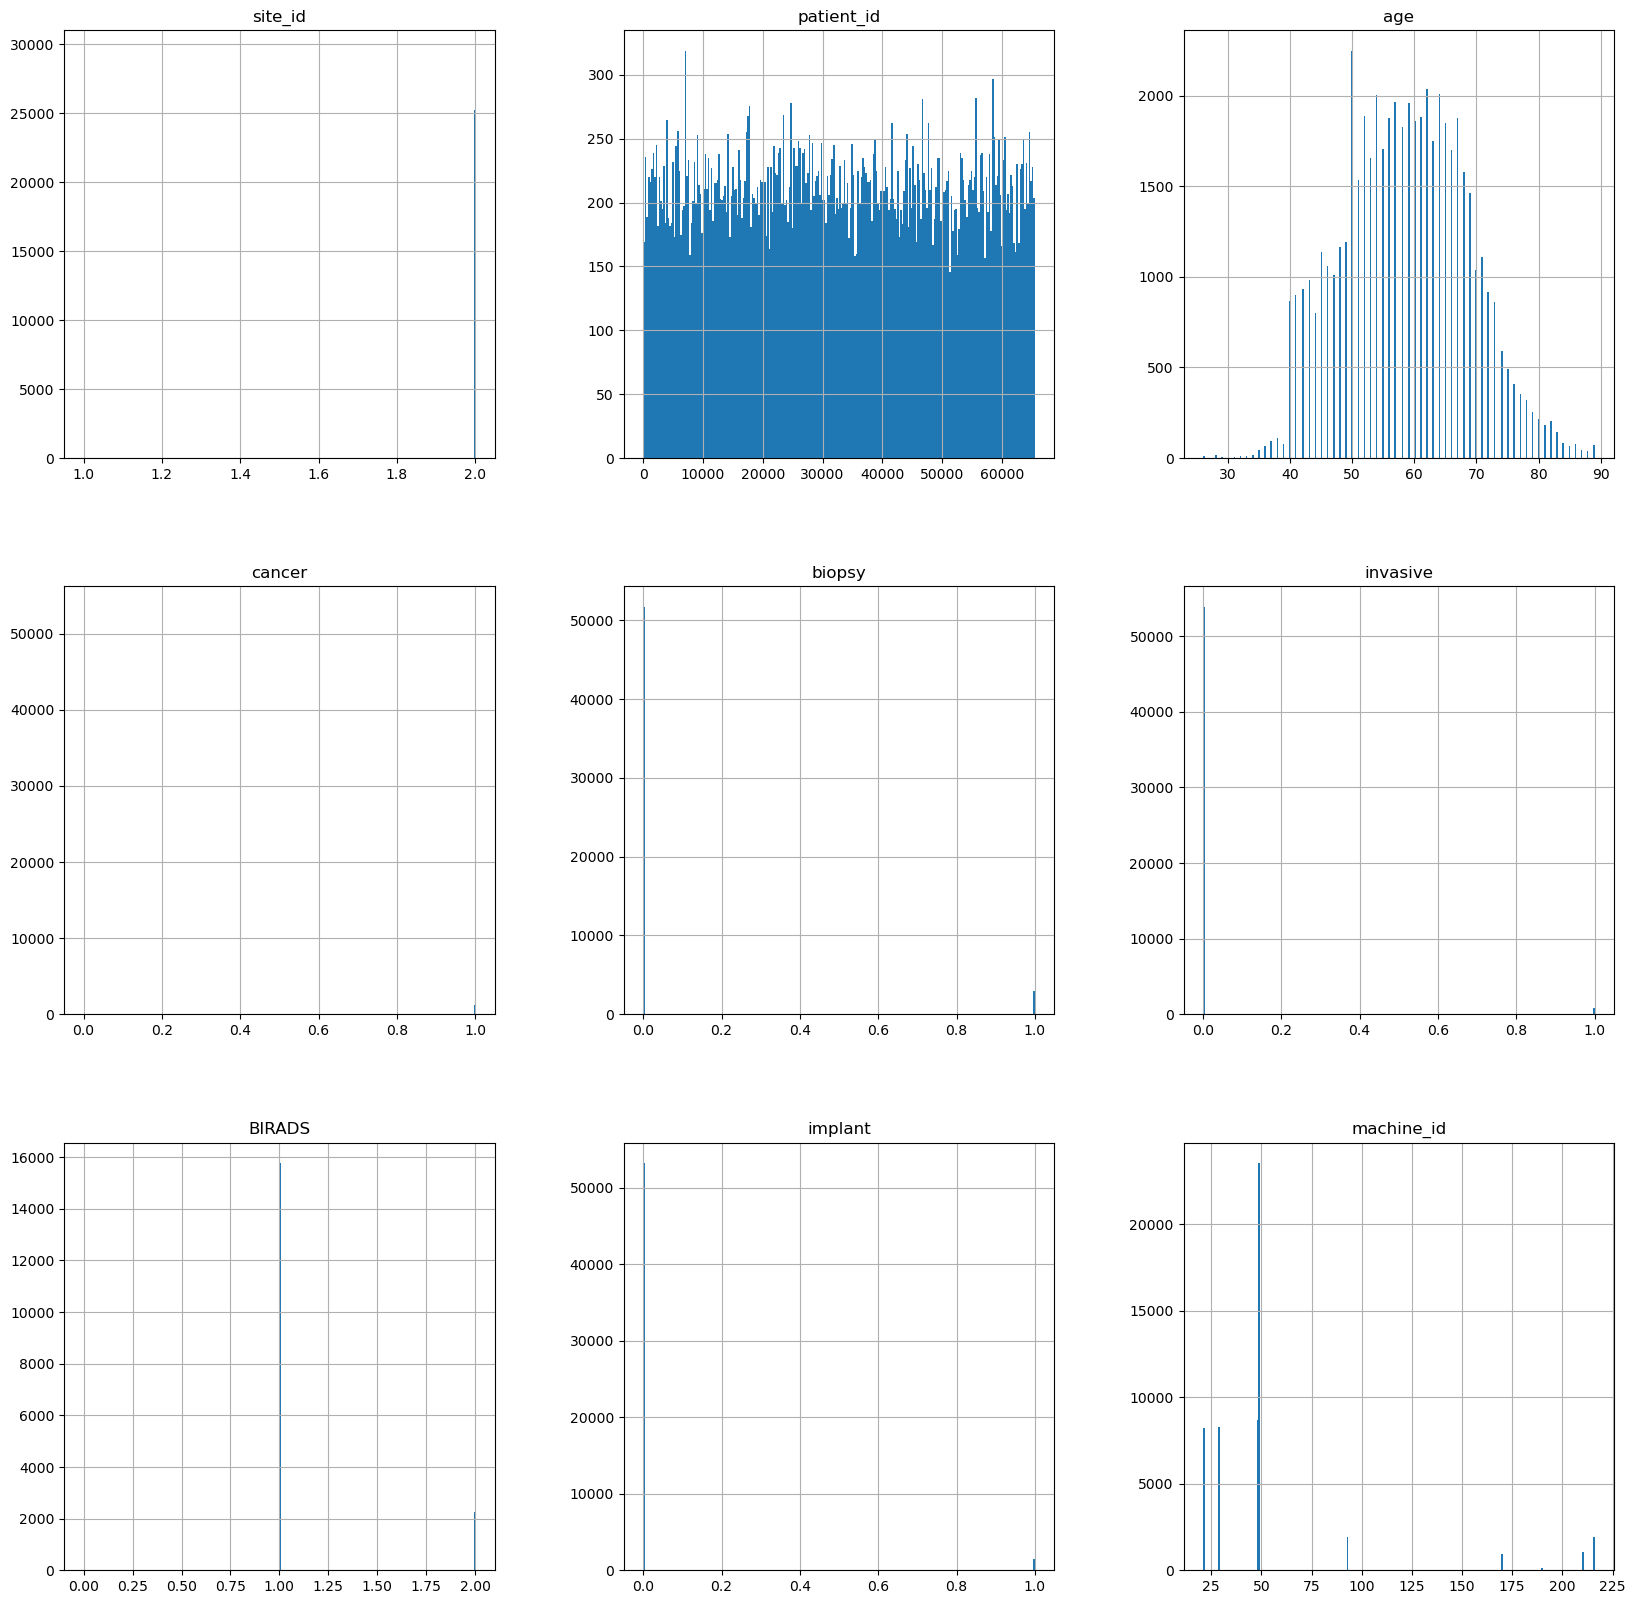

In [29]:
#Histogram Distribution of Numeric Columns Distribution Shapes
all_cancer_df.hist(figsize=(20,20), bins=256)
plt.show()

In [30]:
all_cancer_df.describe()

,site_id,patient_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,54669.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,58.543928,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,10.050884,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;">      <h4> Finding</h4>
 The age feature from the above study provides us with the following information
    <li>Min Age: 26
    <li>Mean Age: 58
    <li>Max Age : 89



<div style="border: 2px solid #fed766; padding: 20px;">
    <h3>E. Demographic Analysis

In [31]:
# visualize categorical distributions
def visualize_distributions(df, title, x_label):
    df.plot(kind='barh')  
    plt.xlabel("Frequency [Count]");
    plt.ylabel(x_label);
    plt.title(title)

## VISUALIZATION OF CATEGORICAL FEATURES

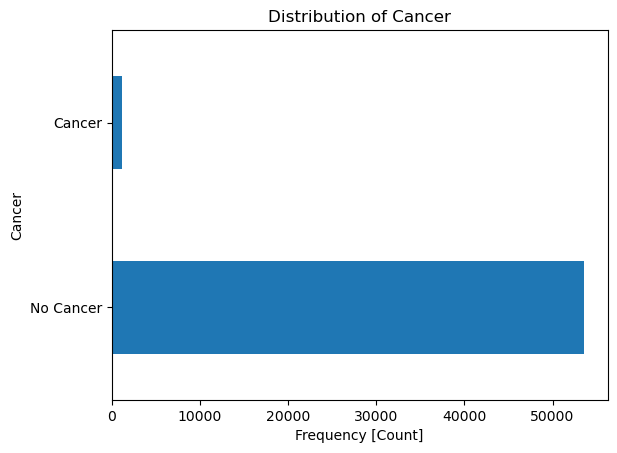

In [32]:
#Cancer Distribution
columns = all_cancer_df["cancer"].replace({0:"No Cancer", 1:"Cancer"}).value_counts()
visualize_distributions(columns, "Distribution of Cancer", "Cancer")

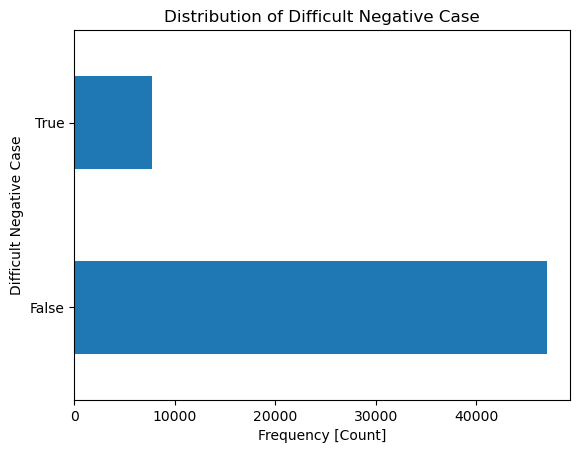

In [33]:
columns = all_cancer_df["difficult_negative_case"].value_counts()
visualize_distributions(columns, "Distribution of Difficult Negative Case", "Difficult Negative Case")

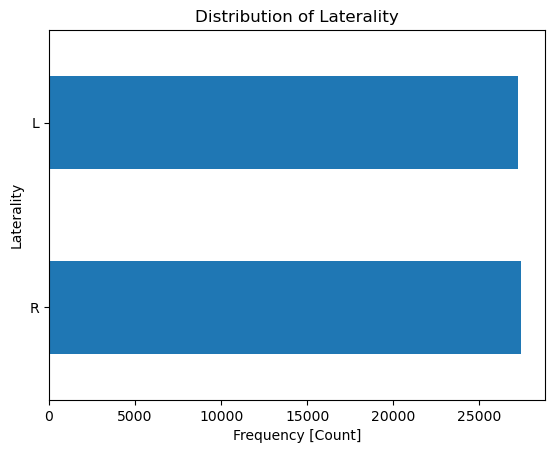

In [34]:
columns = all_cancer_df["laterality"].value_counts()
visualize_distributions(columns, "Distribution of Laterality", "Laterality")

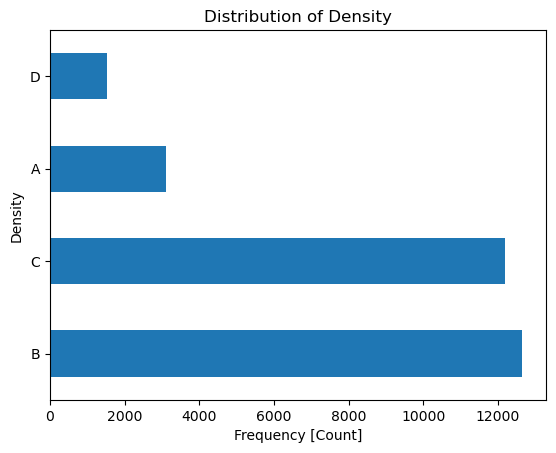

In [35]:
columns = all_cancer_df["density"].value_counts()
visualize_distributions(columns, "Distribution of Density", "Density")

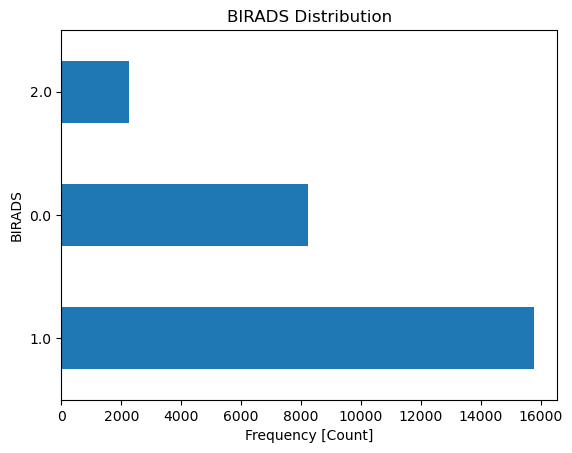

In [36]:
columns = all_cancer_df["BIRADS"].value_counts()
visualize_distributions(columns, "BIRADS Distribution", "BIRADS")

<div style="background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
    The Following Insight was gleaned about the dataset,
    <li> <b>Cancer</b>: This is the target Feature with <b>0</b> Meaning No Cancer & <b>1</b> for Cancer: Our Visualization shows an imbalance between Cancer <br/> and No Cancer
    <li> <b>Laterality</b>: Determines if image is of the left or right breast which showed to be balanced
    <li> <b>Difficulty Negative Case</b>: This Feature determines whether or not the breast was positive for cancer. From the Visualization above this seem there fewer cases of with difficulty
    <li> <b>BIRADS</b>: 0 if the breast required follow-up,
1 if the breast was rated as negative for cancer, and
2 if the breast was rated as normal. Only provided for train. This Feature is unevenly distributed across categories
    <li> <b>Density</b>: A rating for how dense the breast tissue is, with A being the least dense and D being the most dense: The plot above shows that Category B and C are most prevalent in the dataset and Category D and A Less prevalent in the dataset

In [37]:
#Count Function to plot and Compare distributions
def count_plot(x,h, x_label,  data):   
    ax = sns.countplot(x=x, hue=h, data=data[data[h].isnull() == False])    
    ncount = len(data)
    sns.set(font_scale = 1)
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y),ha='center', va='bottom') 

Text(0, 0.5, 'Frequency [Count]')

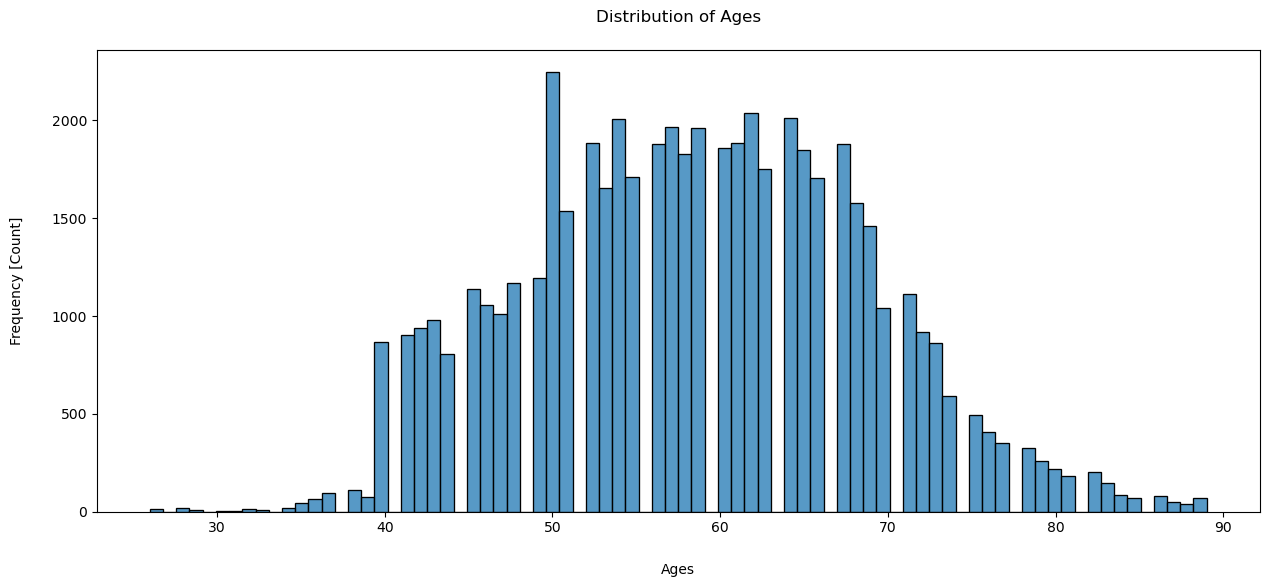

In [38]:
#Demographic Data for Age and Gender Distribution
#Grouping age into buckets
age_bins = np.arange(0, 90, 10)
a_bin = [str(x) for x in np.arange(0, 90, 10) ]
age_labels  = ["".join(x) for x in zip( [x + " - " for x in a_bin[:-1]], a_bin[1:])]
all_cancer_df["age_bin"] = pd.cut(all_cancer_df['age'], bins=age_bins, labels=age_labels)
plt.figure(figsize=(15, 6))
ax = sns.histplot( all_cancer_df, x="age")
plt.title('Distribution of Ages', pad=20)
plt.xlabel("Ages", labelpad=20)
plt.ylabel("Frequency [Count]", labelpad=20)

<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
 The age feature from the above study provides us with the following information
    <li>Min Age: 26
    <li>Max Age : 89


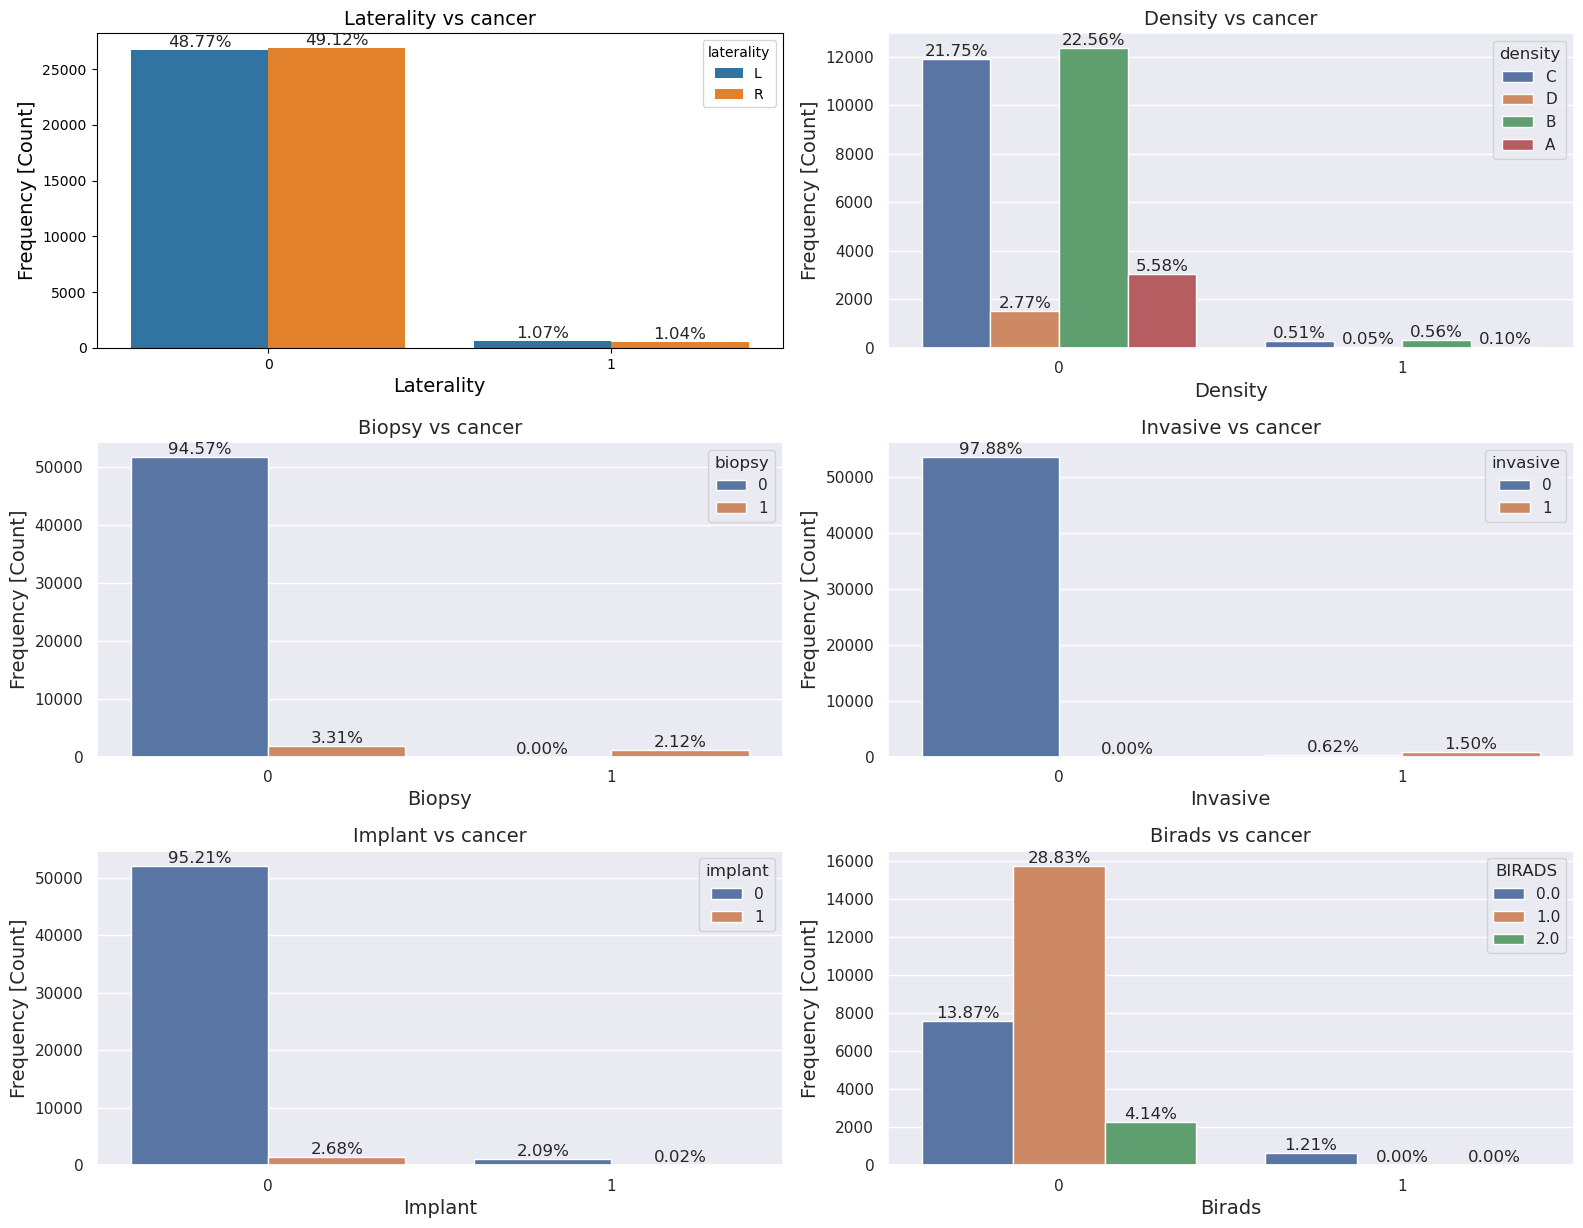

In [39]:
features = ["laterality", "density", "biopsy", "invasive","implant","BIRADS"]
plt.figure(figsize=(16, 16))
for i , col in enumerate(features):
    ax = plt.subplot(4, 2, i + 1)    
    count_plot("cancer",col,col.capitalize(),  all_cancer_df)
    ax.set_xlabel(col.capitalize(), size=14)
    ax.set_ylabel("Frequency [Count]", size=14) 
    ax.set_title(f"{col.capitalize()} vs cancer", size=14)
plt.tight_layout()

Text(0.5, 1.0, 'View vs cancer')

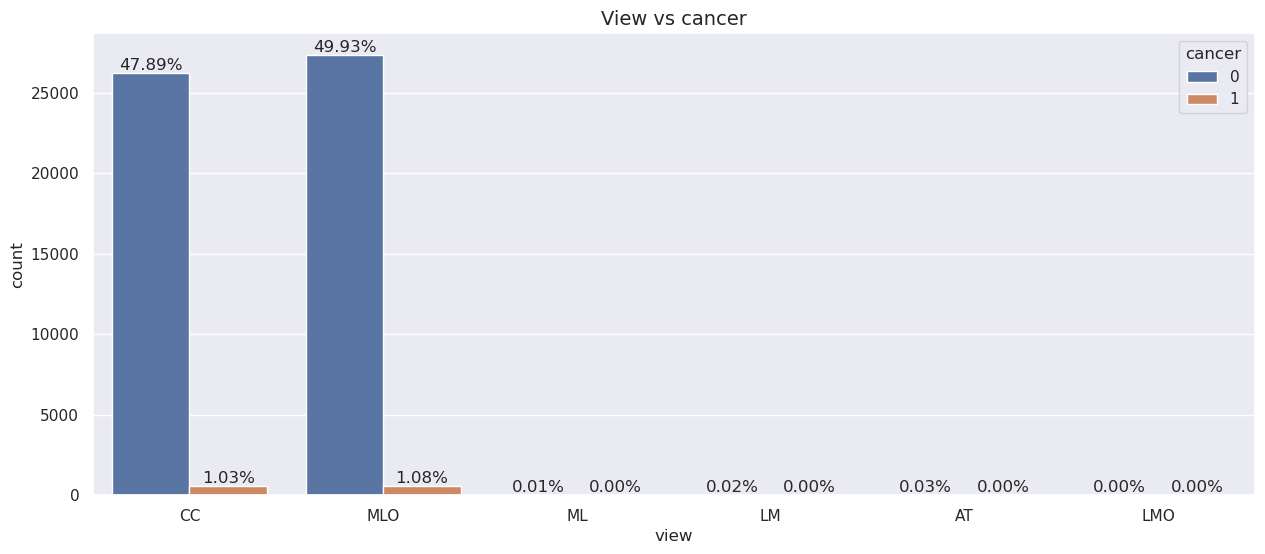

In [40]:
#Demographic Data for View and Cancer Distribution
plt.figure(figsize=(15, 6))
count_plot("view","cancer","cancer",all_cancer_df )
plt.title(f"View vs cancer", size=14)

<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
 From the plot above we can not conclude which feature is more prevalent in a Cancer or No Cancer cases. However from the View vs Cancer Histogram we can see that CC and MLO are usually associated with no cancer cases


<div style="border: 2px solid #fed766; padding: 20px;">
    <h3>F. Outlier Detection

<AxesSubplot:ylabel='age'>

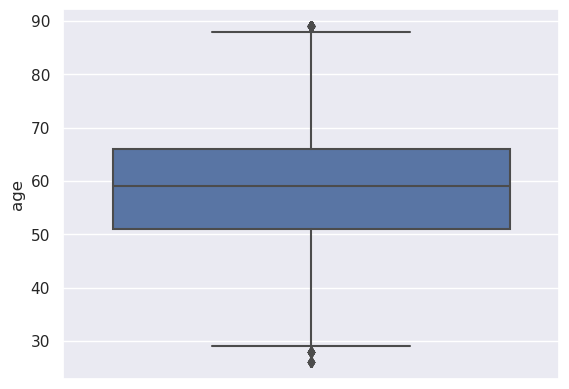

In [41]:
#Outliers
sns.boxplot(y=all_cancer_df['age'])

<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
 The Age Feature Has some Outliers

<div style="border: 2px solid #fed766; padding: 20px;">
    <h3>G. Correlation Matrix </h3>

<AxesSubplot:>

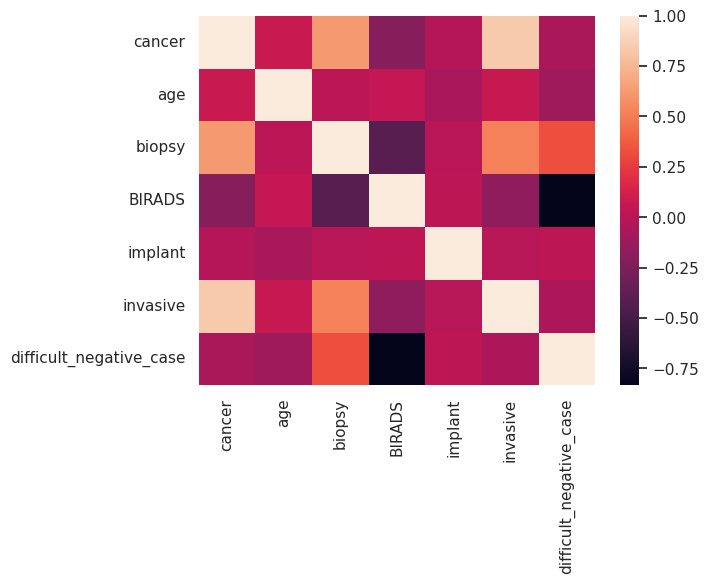

In [42]:
# Calculate the correlation matrix
corr = all_cancer_df[['cancer', 'age', 'view', 'laterality', 'biopsy', 'BIRADS', 'implant', 'invasive', 'density', 'difficult_negative_case']].corr()

# Heatmap of the correlation matrix
sns.heatmap(corr)

<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
 The Age Feature Has some Outliers

<div style="border: 2px solid #fed766; padding: 20px;">
    <h3>H. Image Attributes </h3>
<li> Image Collection Modality and Demography
<li> Are they grey scale or RGB images
<li>  What part of the body are present in the image
<li>  Do Images from in the Dataset Look different if Yes Can I identify what makes them different
<li>  What is the intensity of the images (Do Images of the same Labels have the same intensity Profile or Distributions)
<li>  What can we learn about the distribution of image sizes
<li> How were the images Collected


## Image Collection Modalities and Demography

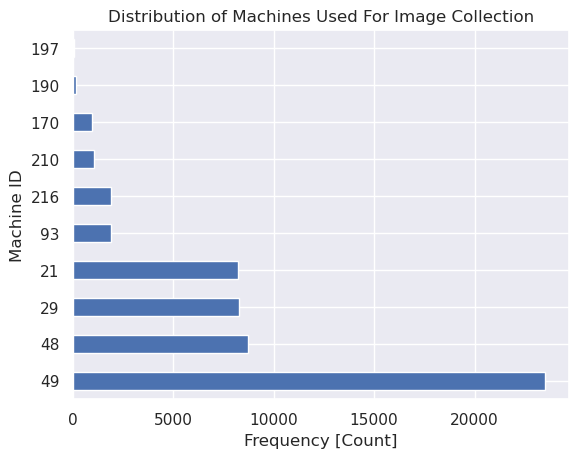

In [43]:
#Cancer Distribution
columns = all_cancer_df["machine_id"].value_counts()
visualize_distributions(columns, "Distribution of Machines Used For Image Collection", "Machine ID")

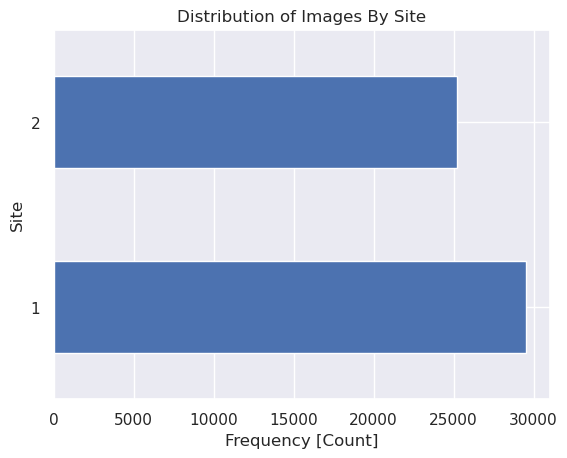

In [44]:
#Cancer Distribution
columns = all_cancer_df["site_id"].value_counts()
visualize_distributions(columns, "Distribution of Images By Site", "Site")

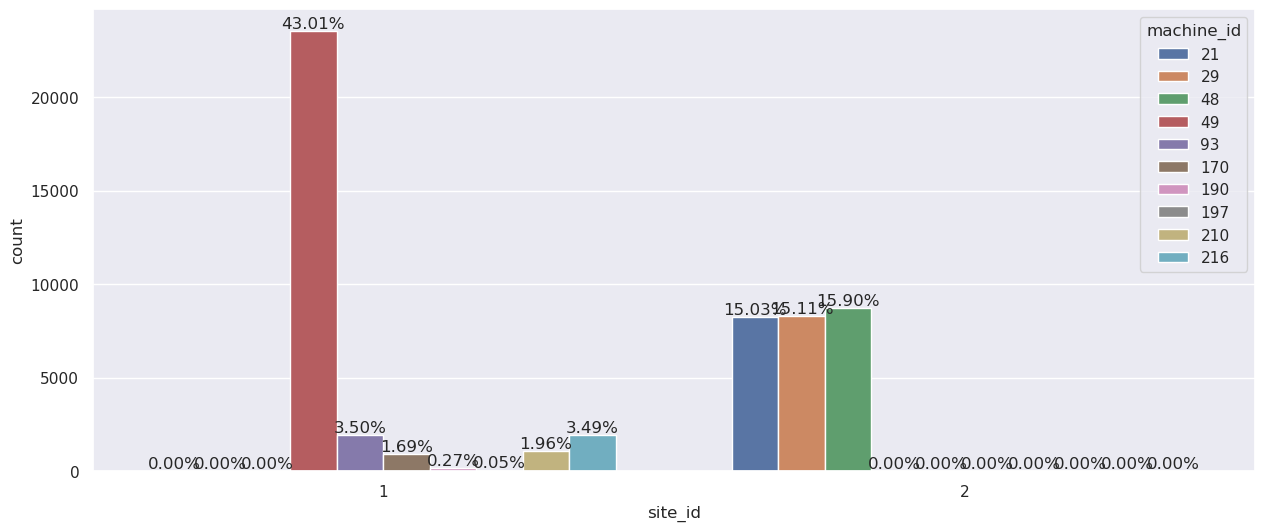

In [45]:
#Demographic Data for View and Cancer Distribution
plt.figure(figsize=(15, 6))
count_plot("site_id","machine_id","Machine Id",all_cancer_df )

In [46]:
all_cancer_df.groupby("site_id")["machine_id"].value_counts()

site_id  machine_id
1        49            23529
         93             1915
         216            1908
         210            1070
         170             923
         190             145
         197              29
2        48             8699
         29             8267
         21             8221
Name: machine_id, dtype: int64

<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
 <li> From the Data 10 Different Machines Were used as imagine modality
 <li> Images were collected at 2 distinct Locations (Site 1 and Site 2)
 <li> Seven Distinct Machines where in Site 1 and Three Distinct Machines for Site 2
 <li> Machine with Id 49 had the highest number of images

## Check Images Sizes 

In [47]:
def check_get_files(dataset,label, sample):  
    machine_ids = dataset['machine_id'].unique()    
    img_sizes = []
    img_pixel = []
    for i, machine_id in enumerate(machine_ids):
        img_machine_id= img_df.loc[(dataset['machine_id'] == machine_id) & (dataset['cancer'] == label)][:sample]       
        if len(img_machine_id) >= 1:
            for i in range(len(img_machine_id)):
                path = img_machine_id.iloc[i]['path']
                img = pydicom.dcmread(path).pixel_array
                img_sizes.append({
                    "machine_id":machine_id,
                    "width":img.shape[0],
                    "height":img.shape[1], 
                    "view":img_machine_id.iloc[i]['view'],
                    "img_pixel":img_pixel

                })  
                img_pixel.append(img)  

    return pd.DataFrame(img_sizes), img_pixel

In [48]:
img_df = all_cancer_df[["machine_id", "cancer","view", "path"]].copy()   
img_df = img_df.replace({0:"No Cancer", 1:"Cancer"})
random_img_sizes, cancer_imgs = check_get_files(img_df,"Cancer",2)
_, no_cancer_imgs = check_get_files(img_df,"No Cancer",2)

In [49]:
def show_images(img_pixel,axs,title, intensity=True):     
    #img = img_pixel.astype(float)
    #img /= np.max(img)    
    img = img_pixel
    img = (img - img.min()) / (img.max() - img.min())
    axs.axis('on')
    axs.set_title(f'{title}')    
    
    if intensity:
        #create distributions of intensity values of the pixel-level data 
        axs.axis('on')       
        
        plt.hist(img.ravel()*255, bins=56)
    else:      
        
        axs.imshow(img, cmap="gray")

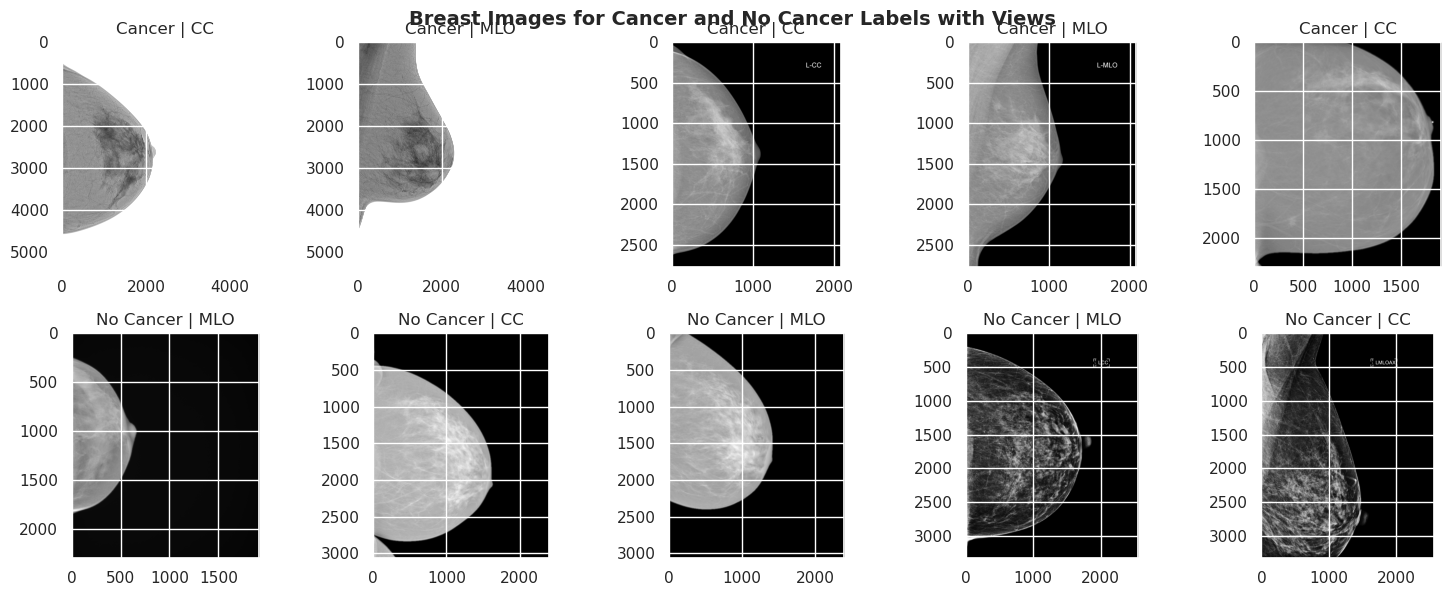

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axs = axs.ravel()
for i, ax in enumerate(axs):  
    if i <=4:
        show_images(cancer_imgs[i],ax,f"Cancer | {random_img_sizes['view'][i]}", intensity=False)  
    if i >=5:
        show_images(no_cancer_imgs[i],ax,f"No Cancer | {random_img_sizes['view'][i]}", intensity=False)

plt.figtext(0.5,0.99, "Breast Images for Cancer and No Cancer Labels with Views", ha="center", va="top", fontsize=14, fontweight='bold')
plt.tight_layout()

<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
   <p> Here we look at the images and the orientations of the image. TWe noticed that the default for a screening exam is to capture two views per breast.The images has the following views
 <li>MLO : Mediolateral oblique which is a type of mammogram view that shows the breast from the side and slightly from above.
 <li>CC: Cranio-caudal which is a type of mammogram view that shows the breast from the top to bottom direction
 <li>AT: Axillary tail which is an extension of the breast tissue that extends into the armpit.
 <li>LM: Lateral Medial which is a type of mammogram view that shows the breast from the side and slightly from below.
 <li>ML: Medial Lateral which is a type of mammogram view that shows the breast from the side and slightly from above.
 <li>LMO: Lateromedial oblique which is a type of mammogram view that shows the breast from the side and slightly from below, opposite to the MLO view


## Image Intensities

Text(0.5, 0.99, 'Cancer Image Intensity')

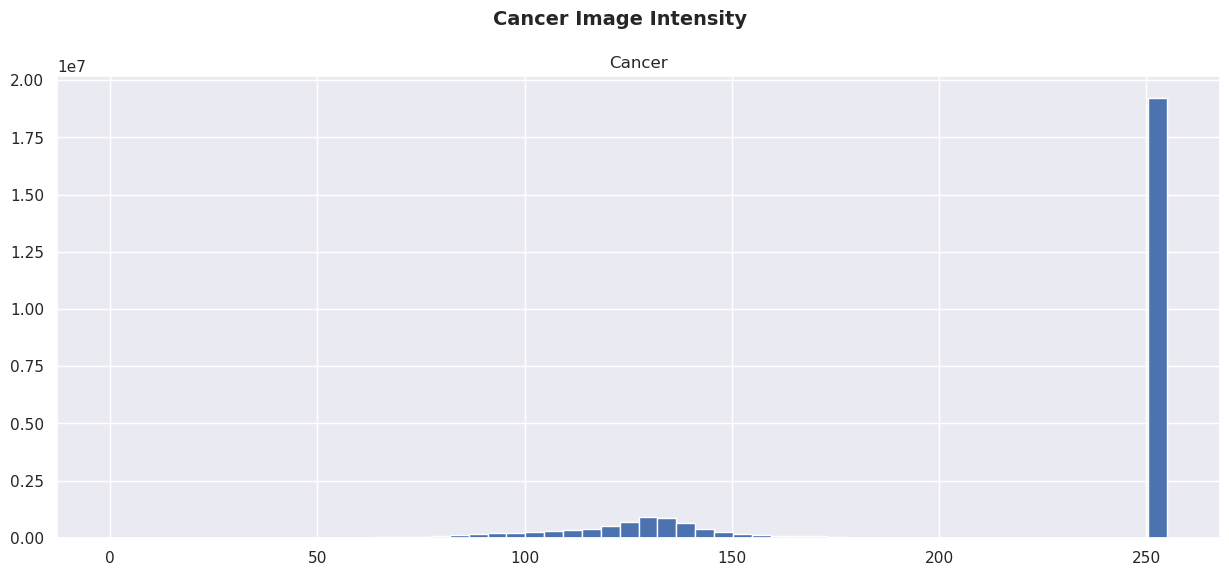

In [51]:
fig, axes = plt.subplots(figsize=(15, 6))
show_images(cancer_imgs[1],axes,"Cancer", intensity=True) 
plt.figtext(0.5,0.99, "Cancer Image Intensity", ha="center", va="top", fontsize=14, fontweight='bold')


Text(0.5, 0.99, 'Cancer Image Intensity')

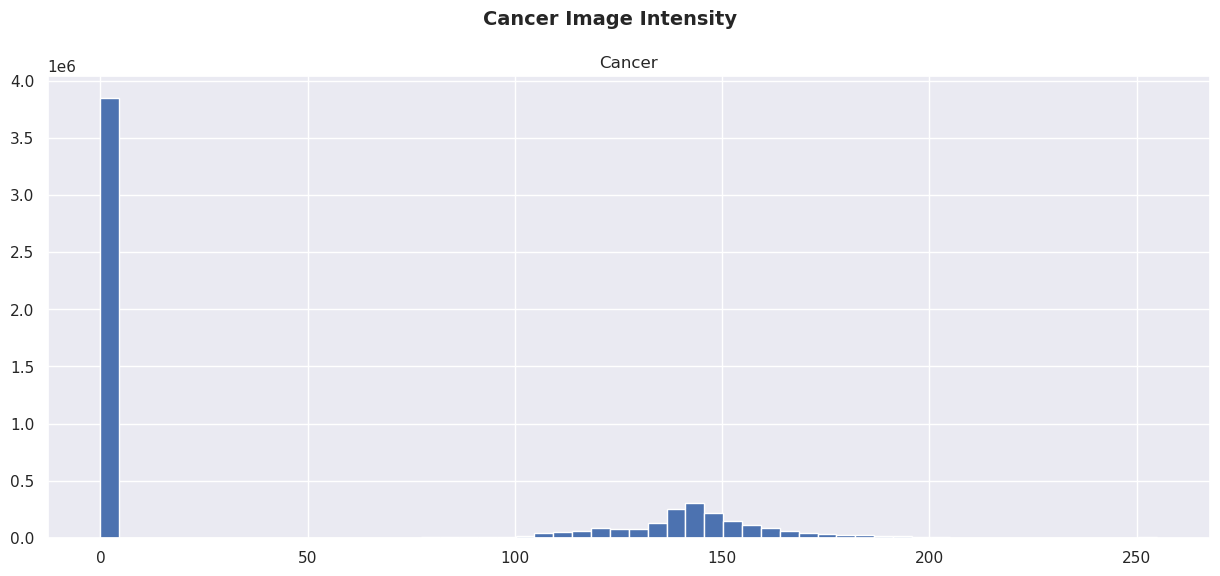

In [52]:
fig, axes = plt.subplots(figsize=(15, 6))
show_images(cancer_imgs[2],axes,"Cancer", intensity=True) 
plt.figtext(0.5,0.99, "Cancer Image Intensity", ha="center", va="top", fontsize=14, fontweight='bold')


<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
   <p> From the randomly sampled image intensities of Cancer Cases. We can see that the spike intensity at 0 accounts for the dark image background
       Also we can see that the intensity lies between 110 and 200


Text(0.5, 0.99, 'No Cancer Intensity')

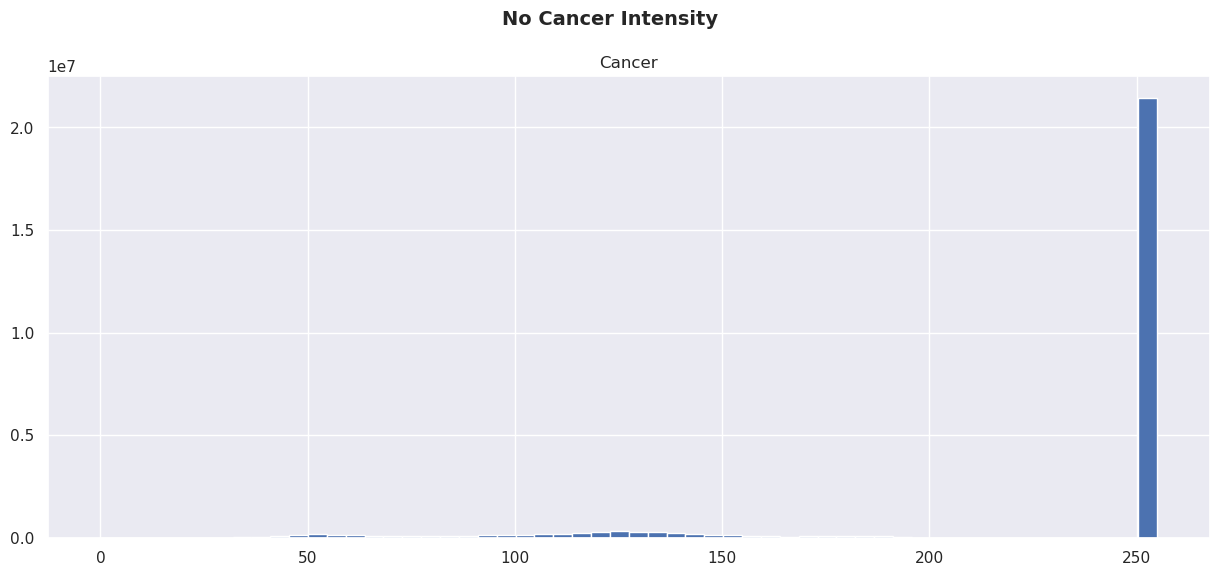

In [53]:
fig, axes = plt.subplots(figsize=(15, 6))
show_images(no_cancer_imgs[1],axes,"Cancer", intensity=True) 
plt.figtext(0.5,0.99, "No Cancer Intensity", ha="center", va="top", fontsize=14, fontweight='bold')


Text(0.5, 0.99, 'No Cancer Intensity')

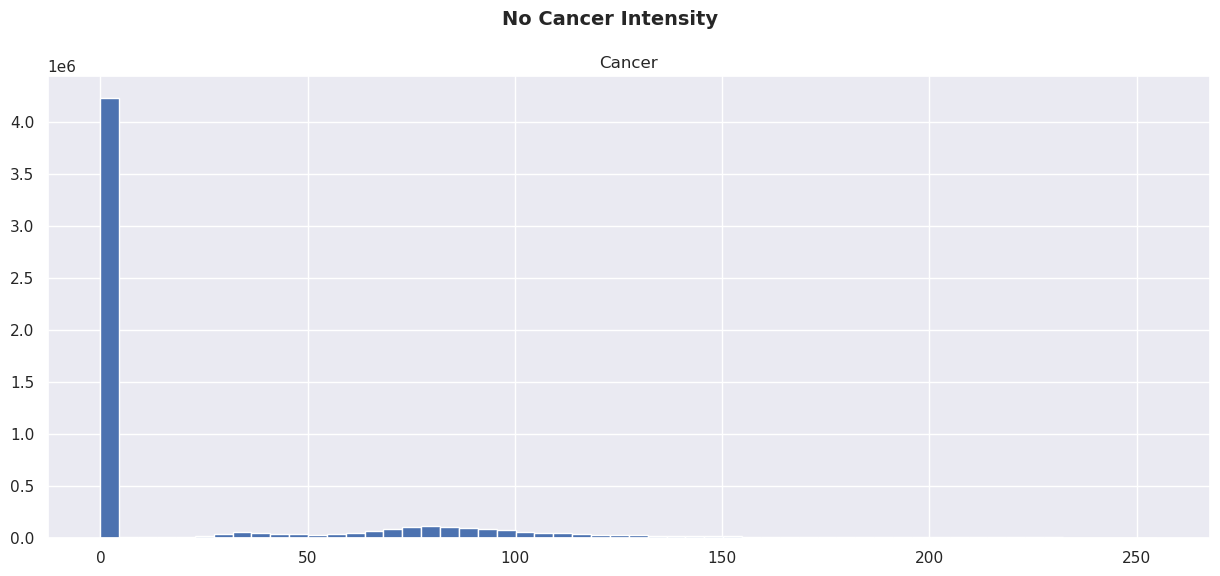

In [54]:
fig, axes = plt.subplots(figsize=(15, 6))
show_images(no_cancer_imgs[2],axes,"Cancer", intensity=True) 
plt.figtext(0.5,0.99, "No Cancer Intensity", ha="center", va="top", fontsize=14, fontweight='bold')


<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
   <p> Here  spike intensity is at 0 and 250 
       Also we can see that the intensity lies between 30 and 150. Also we can notice that the intensity spike is less intense at this region as compared to the cancer cases

In [55]:
random_img_sizes.head(10)

,machine_id,width,height,view,img_pixel
0,29,5355,4915,CC,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
1,29,5355,4915,MLO,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
2,21,2776,2082,CC,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
3,21,2776,2082,MLO,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
4,216,2294,1914,CC,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
5,216,2294,1914,MLO,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
6,93,3062,2394,CC,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
7,93,3062,2394,MLO,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
8,49,4096,3328,MLO,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."
9,49,4096,3328,CC,"[[[3236, 3236, 3236, 3236, 3236, 3236, 3236, 3..."


<div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #fe4a49; padding: 20px;"> <h4> Finding</h4>
   <p> Looking at the image Width and Heights, We can conclude that the image dimensions of the images was determined at random.
       As Images captured by the different machines had different dimensions also it was observed that even images captured  by the same imaging modality had different dimensions. Thus the need for resizing of the images

<i><div style="font-size:14px; background-color: #e6e6ea; border-left: 5px solid #2ab7ca; padding: 20px;">
    <h4>PreProcessing</h4>
    <p> From my EDA Above we came to a conclusion that the following should be done
    <li> We will keep only columns found in the test and training csv files
    <li> We also decided that we will using the mean <b> 58 </b> imputation strategy to account for the missing values found in our EDA
    <li> We also concluded that our data needs to be resized and converted to PNG which can be used for model training
    <li> We also concluded that the categorical data should be onehot encoded
        

### Missing Values

In [56]:
print(BOLD+'Number of Missing Values in Age:',END, all_cancer_df["age"].isna().sum())
all_cancer_df['age'] = all_cancer_df['age'].fillna(58)

Number of Missing Values in Age:  37


### Features Kept

In [58]:

training_df = all_cancer_df[["patient_id","image_id","laterality", "view", "age", "implant", "path", "cancer"]]

# Encode categorical variables
laterality_encoded = LabelEncoder()
view_encoded = LabelEncoder()

training_df['laterality'] = laterality_encoded.fit_transform(training_df['laterality'])
training_df['view'] = view_encoded.fit_transform(training_df['view'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
training_df

In [61]:
save_folder = "output/"
size = 256
extension = "png"
os.makedirs(save_folder, exist_ok=True)

In [59]:
def process(f, size=512, save_folder=None, dicom_process = True, extension="png"):
    
    patient = f.split('/')[-2]
    image_name = f.split('/')[-1][:-4]
    if dicom_process:
        dicom = pydicom.dcmread(f)
        img = dicom.pixel_array

        img = (img - img.min()) / (img.max() - img.min())

        if dicom.PhotometricInterpretation == "MONOCHROME1":  
            img = 1 - img
            
        image = (img * 255).astype(np.uint8) 
    
    img = cv2.resize(image, (size, size))

    file_name = f'{save_folder}' + f"{patient}_{image_name}.{extension}"

    cv2.imwrite(file_name, img)

In [71]:
start_time = time.time()        
Parallel(n_jobs=4)(
    delayed(process)(img, size = 512, save_folder = save_folder, dicom_process = True)
    for img in tqdm(training_df["path"][:10])   
)

print(time.time() - start_time)

  0%|          | 0/10 [00:00<?, ?it/s]

8.833600044250488


In [95]:
cropped_images = glob.glob("/kaggle/working/output/*.png")

In [121]:
def show_images(dataset,sample=2, rows=1, cols=4, intensity=True):
    image_path = dataset[:sample]
    
    for i, path in enumerate(image_path):        
        #Plot the figure and set the figure title
        plt.subplot(rows,cols, i+1)      
        #Read the image 
        var = plt.imread(path)        
        
        if intensity:
            #create distributions of intensity values of the pixel-level data
            plt.hist(var.ravel()*512, bins=56)
        else:
            #Show Images
            plt.imshow(var, cmap="gray")         
                      

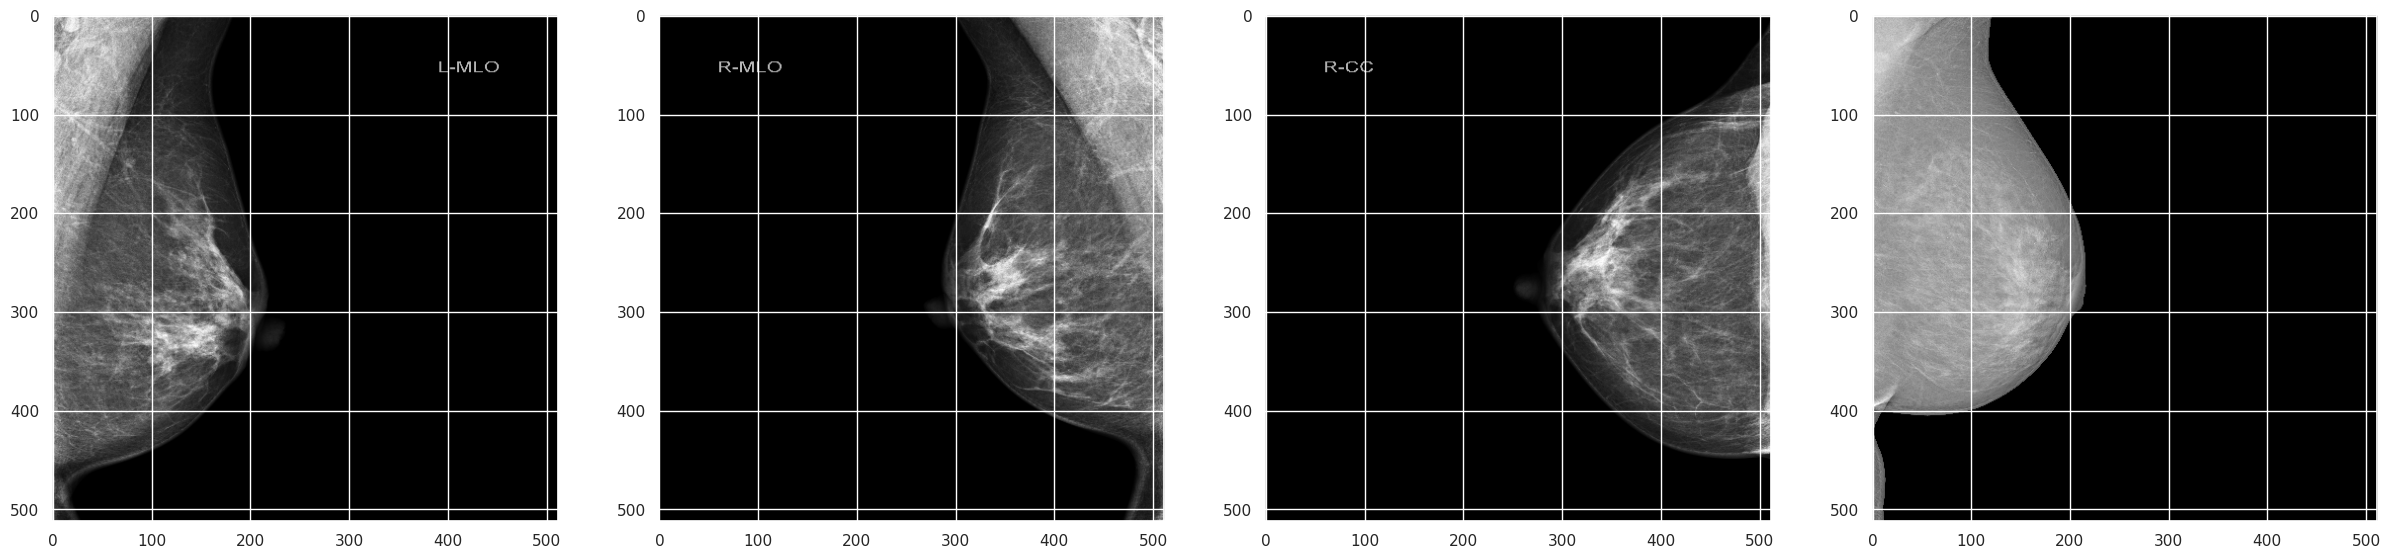

In [114]:
plt.figure(figsize=(30,10))
show_cropped_images(cropped_images,4, rows=1, cols=4, intensity=False)